# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **economic activity or measures** (see below) for the region of **Farmington, Michigan, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Farmington, Michigan, United States** to Ann Arbor, USA. In that case at least one source file must be about **Farmington, Michigan, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Farmington, Michigan, United States** and **economic activity or measures**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **economic activity or measures**?  For this category you might look at the inputs or outputs to the given economy, or major changes in the economy compared to other regions.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

# Region and Domain

    Region : Myanmar
    Domain : Employment Demographic
    Source : https://www.dop.gov.mm/en/data-and-maps

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator as mpl_il
from matplotlib.widgets import CheckButtons
import matplotlib.gridspec as gridspec
                         

In [2]:
%matplotlib notebook

### Population 5 years and over by labour force participation rate, unemployment rate and employment to population ratio by sex and age group, Union

In [3]:
# import data
df = pd.read_excel("~/workspace/datasets/ics_pr_labourforce_en_0.xlsx", sheet_name=1, header=1)

### Clean df

In [4]:
# drop redundunt columns
df.drop(columns=df.columns[4:], inplace=True)
# fix misspelling 
df.rename(columns={'Total Populaton':'Total Population'}, inplace=True)

# find row separator indices
both = df[df.Age=="Both sexes"].index[0]
male = df[df.Age=="Male"].index[0]
female = df[df.Age=="Female"].index[0]
# record the aggregate data for later use
df_both = df[both:male]
both_total_df = df.loc[0]
male_total_df = df.loc[male]
female_total_df = df.loc[female]

In [5]:
def extract_gender(df):
    '''Drop aggregated "Both sexes" rows and extract gender, returns modified dataframe'''
    
    df['Gender'] = None # create a gender column
    
    # get row indices
    both = df[(df.Age=="Both Sexes") | (df.Age=="Both sexes")].index[0]
    male = df[df.Age=="Male"].index[0]
    female = df[df.Age=="Female"].index[0]
    
    df = df.drop(df[both:male].index) # drop aggregated "Both sexes" rows
    
    # fill Gender data and drop gender aggregates
    df.loc[male:female-1, 'Gender'] = "Male"
    df.loc[female:, 'Gender'] = "Female"
    df = df.drop([male, female])
    df = df.reset_index(drop=True)
    
    return df

df = extract_gender(df)

# get names of numerical cols for df
numeric_cols = df.columns.values[1:-1]

In [6]:
def get_bins(df, start, end):
    # drop unwanted agg rows
    age_agg = df[df.Age.isin(["5+", "10+", "15+", "10-17", '15-64'])].index.values
    df = df.drop(age_agg)
        
    bins = [4,9,14,19]
    labels = ['5-9', '10-14', '15-19']
    binned_age = pd.cut(df.Age[start:end].astype(int), bins=bins, labels=labels)
    
    df.iloc[start:end, 0] = binned_age
    
    df = df.reset_index(drop=True)
    return df

df = get_bins(df, 0, 15)
df = get_bins(df, 30, 45)

In [7]:
def agg_same_bins(df, numeric_cols, start, end, gender=None):
    '''sum rows with same age bins'''
    labels = ['5-9', '10-14', '15-19']
    for age_group in labels:
        temp_df = df[start:end]
        temp_df = temp_df[(temp_df.Age==age_group).values][numeric_cols]
                
        temp_idx = temp_df.index
        temp_sum = temp_df.sum()
        temp_sum['Age'] = age_group
        if gender != None: temp_sum['Gender'] = gender
        
        df.loc[temp_idx[0]] = temp_sum # put agg result in the first row
        df = df.drop(temp_idx[1:])
        
        df = df.reset_index(drop=True)
        
    return df

df = agg_same_bins(df, ['Total Population', 'Employed', 'Unemployed'], 0, 30, "Male")
df = agg_same_bins(df, ['Total Population', 'Employed', 'Unemployed'], 18, 48, "Female")

### Clean df_both

In [8]:
# drop row agg
df_both = df_both.drop(0)
df_both = df_both.reset_index(drop=True)

# get age bins
df_both = get_bins(df_both, 0, 15)

# sum age bins
df_both = agg_same_bins(df_both, ['Total Population', 'Employed', 'Unemployed'], 0, 15)

### Population 5 years and over by current activity status and sex (Union)

In [9]:
# import data
df1 = pd.read_excel("~/workspace/datasets/ics_pr_labourforce_en_0.xlsx", sheet_name=4, header=1)
# rename columns
new_cols = ['Age', 'Total', 'Gov_Employee', 'Priv_Employee', 'Paid_Intern', 'Reg_Employer', 'Self_Employer', 'Help_Family', 'Other']
df1.columns = new_cols

In [10]:
# find row separator indices
both = df1[df1.Age=="Both Sexes"].index[0]
male = df1[df1.Age=="Male"].index[0]
female = df1[df1.Age=="Female"].index[0]

# record the aggregate data for later use
df1_both = df1[both:male] 

both_total_df1 = df1.loc[0]
male_total_df1 = df1.loc[male]
female_total_df1 = df1.loc[female]

### Clean df1

In [11]:
df1 = extract_gender(df1)

df1 = get_bins(df1, 0, 15)
df1 = get_bins(df1, 30, 45)

df1 = agg_same_bins(df1, df1.columns[1:-1], 0, 30, 'Male')
df1 = agg_same_bins(df1, df1.columns[1:-1], 18, 48, 'Female')

### Clean df1_both

In [12]:
# drop row agg
df1_both = df1_both.drop(0)
df1_both = df1_both.reset_index(drop=True)

# get age bins
df1_both = get_bins(df1_both, 0, 15)

# sum age bins
df1_both = agg_same_bins(df1_both, df1.columns[1:-1], 0, 15)

# Plots

In [13]:
male_idx = df1[df1.Gender=="Male"].index
female_idx = df1[df1.Gender=="Female"].index

age_groups = df1_both.Age

total_pop = df_both['Total Population'].values
male_emp = df1.iloc[male_idx]['Total'].values
fem_emp = df1.iloc[female_idx]['Total'].values
# find percent employed for each gender
male_emp = np.round((100*(male_emp/total_pop)), 2)
fem_emp = np.round((100*(fem_emp/total_pop)), 2)

In [14]:
def get_percent(numerator, denominator, decimal_place):
    ans = np.round((100*(numerator/denominator).values), decimal_place)
    return ans

# get nums employed in each emp category for each male age group
labels = ['Government', 'Private', 'Intern', 'Employer_Regular', 'Self Employer', 'Family', 'Others']
m_vals = dict.fromkeys(labels)
for idx, key in enumerate(m_vals):
    m_vals[key] = df1.iloc[male_idx, idx+2]

# get percent employed in each emp category for each male age group 
m_perc = dict.fromkeys(labels)
for idx,key in enumerate(m_perc):
    m_perc[key] = get_percent(m_vals[key], total_pop, 2)

# get nums employed in each emp category for each female age group 
f_vals = dict.fromkeys(labels)
for idx, key in enumerate(f_vals):
    f_vals[key] = df1.iloc[female_idx, idx+2]

# get percent employed in each emp category for each female age group 
f_perc = dict.fromkeys(labels)
for idx,key in enumerate(f_perc):
    f_perc[key] = get_percent(f_vals[key], total_pop, 2)

In [15]:
def plot_stackbars(ax, bar_heights, y_loc, bar_width):
    height_record = list()
    barlist = list()
    first = ax.barh(y_loc, bar_heights['Government'], bar_width, label='Government')
    barlist.append(first)
    height_record.append(bar_heights['Government'])
    
    for idx,val in bar_heights.items():
        if idx == 'Government':
            pass
        else:
            next_bar = ax.barh(y_loc, val, bar_width, label=idx, left=sum(height_record))
            barlist.append(next_bar)
            height_record.append(val)

    return barlist

In [16]:
def make_axes():
    '''create two subplots on figure and return a tuple of left and right axes'''
    left_ax = plt.subplot(gspec[0:,:1])
    right_ax = plt.subplot(gspec[0:,1:])
    left_ax.grid(which='major', axis='both', ls=':', alpha=0.5)
    right_ax.grid(which='major', axis='both', ls=':', alpha=0.5)
    return (left_ax, right_ax)

In [17]:
def print_bar(axes, label, bar_height, y_loc, bar_width, color):
    axes.barh(y_loc, bar_height, bar_width, label=label, color=color)
    
def upperLimit(m_val, f_val):
    m_max = m_val.values.max()
    f_max = f_val.values.max()
    maxval = m_max if m_max > f_max else f_max
    upperlim = maxval + (maxval*0.2)
    return upperlim

<IPython.core.display.Javascript object>


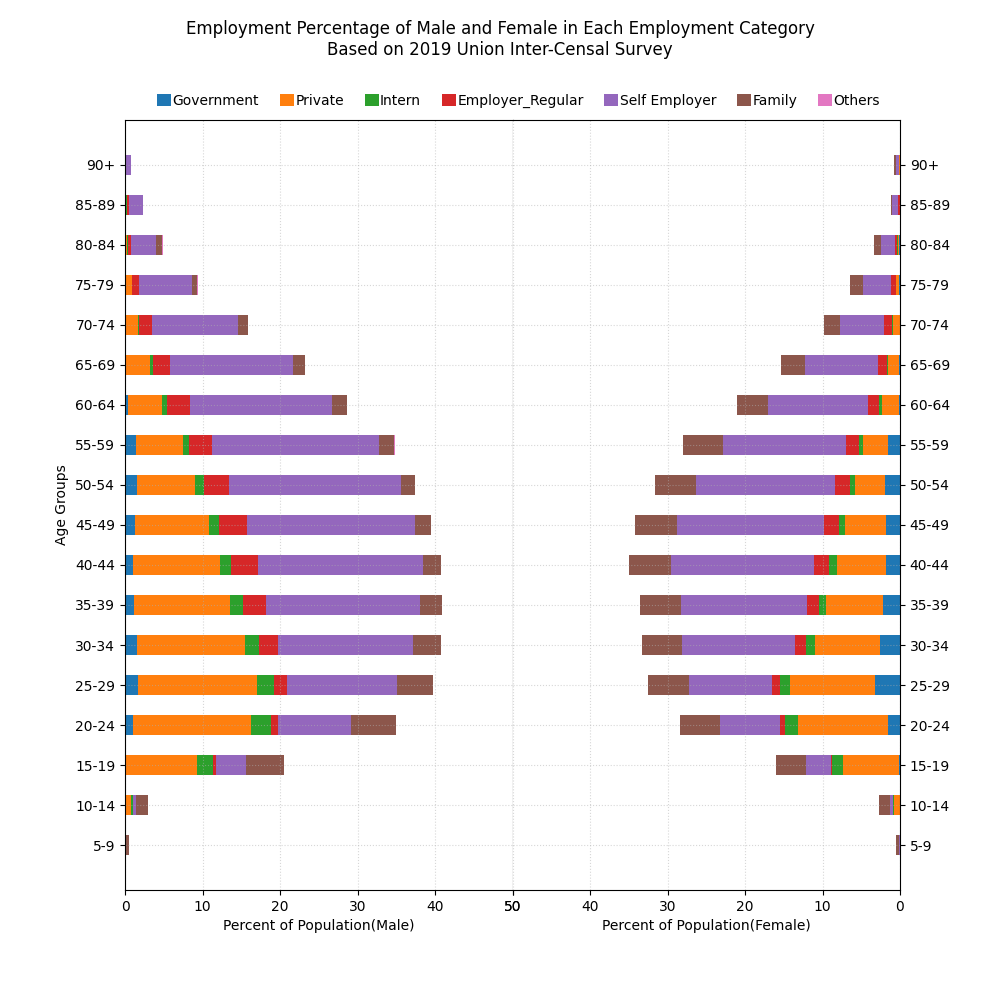

In [18]:
colormap = {'Government':'cornflowerblue', 
           'Private':'darkorange',
           'Intern':'forestgreen',
           'Employer_Regular': 'tab:red',
           'Self Employer':'darkorchid',
           'Family':'sienna',
           'Others':'orchid'}

fig = plt.figure(figsize=(10,10))
gspec = gridspec.GridSpec(2,2)
gspec.update(wspace=0, hspace=0.05) # set the spacing between axes.
y_loc = np.arange(0,18, 1)

left_ax, right_ax = make_axes()
fig.suptitle("Employment Percentage of Male and Female in Each Employment Category\nBased on 2019 Union Inter-Censal Survey")

# plot left bars
malebars = plot_stackbars(left_ax, m_perc, y_loc, 0.5) 

left_ax.set_yticks(y_loc)
left_ax.set_yticklabels(labels=age_groups)
left_ax.set_xlim(0,50)

left_ax.set_ylabel('Age Groups')
left_ax.set_xlabel("Percent of Population(Male)")
right_ax.set_xlabel("Percent of Population(Female)")


#left_twin = left_ax.twiny()
#left_twin.invert_xaxis()

# plot right bars
femalebars = plot_stackbars(right_ax, f_perc, y_loc, 0.5)

right_ax.invert_xaxis()
right_ax.set_xlim(50,0)

right_ax.set_yticks(y_loc)
right_ax.set_yticklabels(labels=age_groups)

#right_twin = right_ax.twiny()

right_yax = right_ax.get_children()[-5]
right_yax.tick_right()

# remove the y axis line in the middle
right_ax.get_children()[-10].set_visible(False)
#right_twin.get_children()[0].set_visible(False)
#left_twin.get_children()[1].set_visible(False)

# create alegend
leg = right_ax.legend(labels=labels,bbox_to_anchor=(0.98,1.05), handlelength=1, handleheight=1, handletextpad=0.1, columnspacing=1.5, ncol=7, edgecolor='white')

# enable legend picking
def onpick(event):
    # identify which label is picked
    selected = event.artist.get_text()
    idx = labels.index(selected)
    
    # clear current bars if not already cleaned
    try:
        for i in malebars: i.remove()
        for i in femalebars: i.remove()
    except ValueError:
        for artist in fig.get_children()[1].get_children()[:18]:
            artist.remove()
        for artist in fig.get_children()[2].get_children()[:18]:
            artist.remove()

    # display selected bar
    upperlim = upperLimit(m_vals[selected], f_vals[selected])
    left_ax.set_xlim(0, upperlim)
    right_ax.set_xlim(0, upperlim)
    right_ax.invert_xaxis()
    
    fig.suptitle(f"Number of Employed Male and Female in {selected} Employment" )
    left_ax.set_xlabel("Employed Num(Male)")
    right_ax.set_xlabel("Percent of Population(Female)")
    
    for label in left_ax.get_xticklabels():
        label.set_rotation(90)
    for label in right_ax.get_xticklabels():
        label.set_rotation(90)
    
    print_bar(left_ax, selected, m_vals[selected], y_loc, 0.5, colormap[selected])
    print_bar(right_ax, selected, f_vals[selected], y_loc, 0.5, colormap[selected])

fig.canvas.mpl_connect('pick_event', onpick)

# get text artists from legend and change picking area sensitivity
txt_artist = list()
for i in range(7):
    txt_artist.append(leg.get_children()[0].get_children()[1].get_children()[i].get_children()[0].get_children()[1].get_children()[0])
for text in txt_artist:
    text.set_picker(5) 

In [19]:
plt.savefig(fname="Labour_demographic.jpeg", dpi=800)